# The Harmony Swath Projector service

This Jupyter notebook demonstrates how to use the Swath Projector, a Harmony backend service that transforms level 2 swath data into a gridded output product. This notebook will cover basic environmental setup and the variety of input arguments that can be given to the service to define the output grid.

### Environment setup:

This notebook assumes that it is being run in a local Python environment, configured using either `pyenv` or conda. Either can be used, but the dependencies will be installed via Pip. To install the required packages to run this notebook:

```bash
$ pip install -r requirements.txt
```

Note - your environment will require the [geos](https://trac.osgeo.org/geos/) package to be able to install all the dependencies for this notebook (particularly `cartopy`).

`harmony-py` is available from [PyPI](https://pypi.org/project/harmony-py/). It can also be installed with Pip:

```bash
$ pip install harmony-py
```

## Authentication setup

We need some boilerplate up front to log in to Earthdata Login.  The function below will allow Python
scripts to log into any Earthdata Login application programmatically.  To avoid being prompted for
credentials every time you run and also allow clients such as curl to log in, you can add the following
to a `.netrc` (`_netrc` on Windows) file in your home directory:

```
machine uat.urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

Make sure that this file is only readable by the current user or you will receive an error stating
"netrc access too permissive."

`$ chmod 0600 ~/.netrc` 


In [1]:
from urllib import request
from http.cookiejar import CookieJar
import getpass
import netrc


def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file 
    first and if no credentials are found, it prompts for them.

    Valid endpoints include:
        uat.urs.earthdata.nasa.gov - Earthdata Login UAT (Harmony's current default)
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('Username:')
        password = getpass.getpass()

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

Now call the above function to set up Earthdata Login for subsequent requests

In [2]:
setup_earthdata_login_auth('uat.urs.earthdata.nasa.gov')

### Plotting utility function:

In [3]:
import numpy as np
from netCDF4 import Dataset

import matplotlib.pyplot as plt
%matplotlib inline


def create_plot(variable_data, x_values, y_values, title=None, colourbar_units=None,
                x_label=None, y_label=None):
    """ This helper function will display a contour plot of the requested data. """
    fig = plt.figure(figsize=(10, 10))

    if title is not None:
        fig.suptitle(title, fontsize=20)

    ax = plt.axes(xlabel=x_label, ylabel=y_label)

    # Plot masked data:
    colour_scale = ax.contourf(x_values[:], y_values[:], variable_data[0][:], levels=20)
    
    # Add colour bar for scaling
    colour_bar = plt.colorbar(colour_scale, ax=ax, orientation='horizontal', pad=0.05)

    if colourbar_units is not None:
        colour_bar.set_label(colourbar_units, fontsize=14)

    plt.tight_layout()
    plt.show()


def plot_variable(file_name, variable, x_variable, y_variable, title, colourbar_units,
                  x_label, y_label):
    """ Open the requested NetCDF-4 file and pass the variables through to the `create_plot`
        function.

    """
    with Dataset(file_name, 'r') as dataset:
        create_plot(dataset[variable], dataset[x_variable], dataset[y_variable], title=title,
                    colourbar_units=colourbar_units, x_label=x_label, y_label=y_label)

### Example data:

In the following cell, the collection and several granule concept IDs are assigned to more human-readable variables. In this notebook, the example Harmony L2 data collection will be used, which contains simulated data mapped to different continents.

In [4]:
collection_id = 'C1233860183-EEDTEST'
granule_ids = {'015_00_210_africa': 'G1233860549-EEDTEST',
               '015_01_210_australia': 'G1233860551-EEDTEST',
               '015_02_210_europe': 'G1233860553-EEDTEST',
               '002_00_028_africa': 'G1233860481-EEDTEST',
               '002_01_028_australia': 'G1233860484-EEDTEST',
               '002_02_028_europe': 'G1233860486-EEDTEST'}

## Building Swath Projector requests

`harmony-py` can be used to build a Harmony request, that will result in the Swath Projector service being called via the Harmony API.

This first request will specify a collection and granule, but rely on default values for all other request parameters. There are further examples later in this notebook detailing the possible parameters that can be specified.

In [5]:
from harmony import Client, Collection, Request, Environment


# Create a client for the UAT environment:
harmony_client = Client(env=Environment.UAT)

# Create a collection instance, using the concept ID:
collection = Collection(id=collection_id)

# Construct a request, ready to send to the Harmony API:
request = Request(collection=collection, granule_id=[granule_ids['002_02_028_europe']])

# Ensure the request is valid:
print(f'Request is valid: {request.is_valid()}')

Request is valid: True


## Submitting requests and tracking progress

Submitting a valid request to Harmony using the `Client` instance will return a job ID. This ID can be used to track the job status using in-built functionality.

{'username': 'olittlej', 'status': 'running', 'message': 'The job is being processed', 'progress': 0, 'createdAt': '2021-06-28T22:03:56.302Z', 'updatedAt': '2021-06-28T22:03:56.302Z', 'links': [{'title': 'Job Status', 'href': 'https://harmony.uat.earthdata.nasa.gov/jobs/187daf85-1279-46e1-a71f-e7263e7234ed', 'rel': 'self', 'type': 'application/json'}], 'request': 'https://harmony.uat.earthdata.nasa.gov/C1233860183-EEDTEST/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?forceAsync=true&granuleId=G1233860486-EEDTEST', 'numInputGranules': 1, 'jobID': '187daf85-1279-46e1-a71f-e7263e7234ed'}

Waiting for the job 187daf85-1279-46e1-a71f-e7263e7234ed to finish


 [ Processing: 100% ] |###################################################| [|]



Downloaded files: ['002_02_028_europe_regridded.nc']


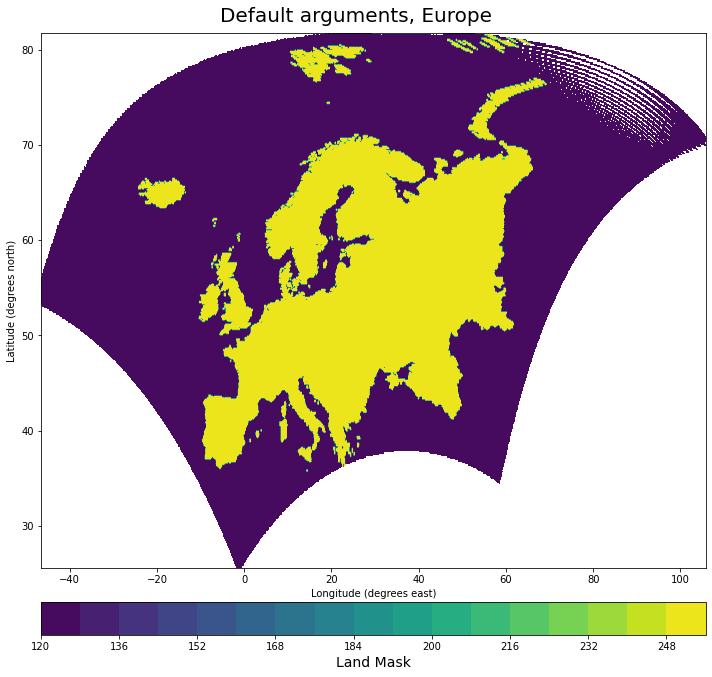

In [6]:
def wait_and_download_results(job_id):
    """ A helper function that waits for a job to complete, and then
        downloads the results.

    """
    print(f'\nWaiting for the job {job_id} to finish')
    results = harmony_client.result_json(job_id, show_progress=True)
    print('\nDownloading results.')
    futures = harmony_client.download_all(job_id, overwrite=True)
    downloaded_files = [future.result() for future in futures]
    print(f'Downloaded files: {downloaded_files}')
    return downloaded_files


# Submit a valid Harmony request via the UAT Harmony client.
job_id = harmony_client.submit(request)

# Obtain the output results:
downloaded_files = wait_and_download_results(job_id)

# Plot results
plot_variable(downloaded_files[0], 'alpha_var', 'lon', 'lat', 'Default arguments, Europe', 'Land Mask',
              'Longitude (degrees east)', 'Latitude (degrees north)')

### Available parameter options:

The Swath Projector can allow a user to make requests that specify several parameters, such as:

* The interpolation method used in projecting to the new grid (currently: "near", "bilinear", "ewa" or "ewa-nn").
* The target grid projection (either as a Proj string or an EPSG code).
* The target grid extents.
* The target grid dimensions (`height` and `width`).
* The target grid pixel scale (in both the x and y dimension).

The following examples will show these options being specified in `harmony-py` requests:

#### Interpolation method:

The default interpolation method is Elliptically Weighted Averaging ([EWA](https://pyresample.readthedocs.io/en/latest/swath.html#pyresample-ewa)).

There are currently 4 interpolation methods accepted by the Swath Projector:

* `bilinear`: [Standard bilinear interpolation](https://pyresample.readthedocs.io/en/latest/swath.html#pyresample-bilinear), that averages the values of nearby input cells.
* `ewa`: Elliptically Weighted Averaging, which accounts for the swath nature of the input data. This averages the values of nearby cells, applying weighting based on an elliptical kernel.
* `ewa-nn` Elliptically Weighted Averaging (Nearest Neighbour). After finding the input pixels with the highest weight to each output pixel, the value of the single pixel with the highest weight is taken for each.
* `near`: [Standard nearest neighbour interpolation](https://pyresample.readthedocs.io/en/latest/swath.html#pyresample-kd-tree). The value of the nearest input pixel is take for each output pixel.

In the following request, the nearest neighbour interpolation method is chosen instead of the default (EWA):

{'username': 'olittlej', 'status': 'running', 'message': 'The job is being processed', 'progress': 0, 'createdAt': '2021-06-28T22:04:32.987Z', 'updatedAt': '2021-06-28T22:04:32.987Z', 'links': [{'title': 'Job Status', 'href': 'https://harmony.uat.earthdata.nasa.gov/jobs/d18ec32f-5c07-4d7f-a27a-0b335c0c5ee9', 'rel': 'self', 'type': 'application/json'}], 'request': 'https://harmony.uat.earthdata.nasa.gov/C1233860183-EEDTEST/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?forceAsync=true&interpolation=near&granuleId=G1233860484-EEDTEST', 'numInputGranules': 1, 'jobID': 'd18ec32f-5c07-4d7f-a27a-0b335c0c5ee9'}

Waiting for the job d18ec32f-5c07-4d7f-a27a-0b335c0c5ee9 to finish


 [ Processing: 100% ] |###################################################| [|]



Downloaded files: ['002_01_028_australia_regridded.nc']


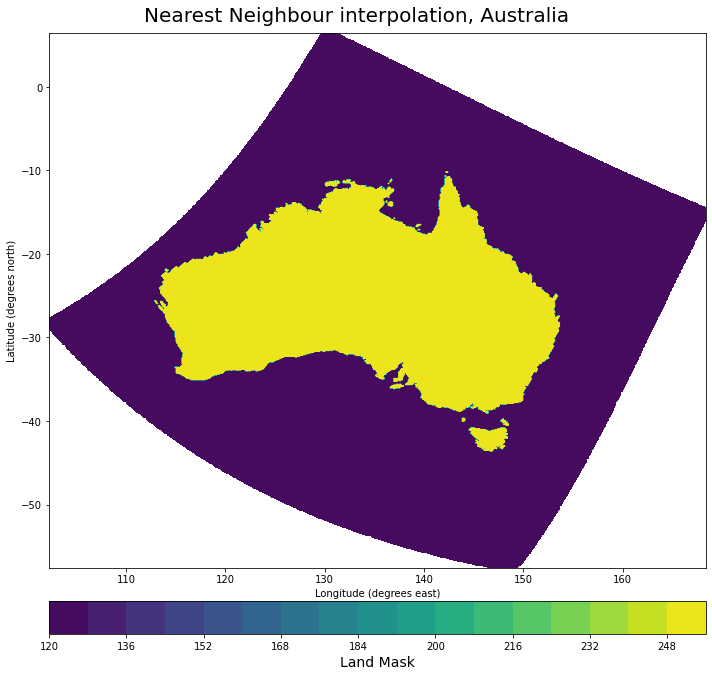

In [7]:
interpolation_options = ['bilinear', 'ewa', 'ewa-nn', 'near']

nearest_neighbour_request = Request(collection=collection,
                                    granule_id=[granule_ids['002_01_028_australia']],
                                    interpolation='near')

nearest_neighbour_job_id = harmony_client.submit(nearest_neighbour_request)
nearest_neighbour_results = wait_and_download_results(nearest_neighbour_job_id)

plot_variable(nearest_neighbour_results[0], 'alpha_var', 'lon', 'lat',
              'Nearest Neighbour interpolation, Australia', 'Land Mask',
              'Longitude (degrees east)', 'Latitude (degrees north)')

#### Target grid extent:

It is possible to define the minimum and maximum values of the x and y dimensions of the target grid used in the output product. This is specified by the `scale_extent` keyword argument when creating a new `Request` instance.

In the example above that uses only default arguments, a request will be made for a granule containing Africa. The `scale_extent` parameter will be used to create a grid that only includes the region of the continent surrounding Chad:

{'username': 'olittlej', 'status': 'running', 'message': 'The job is being processed', 'progress': 0, 'createdAt': '2021-06-28T22:05:16.107Z', 'updatedAt': '2021-06-28T22:05:16.107Z', 'links': [{'title': 'Job Status', 'href': 'https://harmony.uat.earthdata.nasa.gov/jobs/6ee2f2b7-562b-4367-a684-01eae82d07d4', 'rel': 'self', 'type': 'application/json'}], 'request': 'https://harmony.uat.earthdata.nasa.gov/C1233860183-EEDTEST/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?forceAsync=true&scaleExtent=13.3&scaleExtent=7.4&scaleExtent=24.2&scaleExtent=23.7&granuleId=G1233860481-EEDTEST', 'numInputGranules': 1, 'jobID': '6ee2f2b7-562b-4367-a684-01eae82d07d4'}

Waiting for the job 6ee2f2b7-562b-4367-a684-01eae82d07d4 to finish


 [ Processing: 100% ] |###################################################| [|]



Downloaded files: ['002_00_028_africa_regridded.nc']


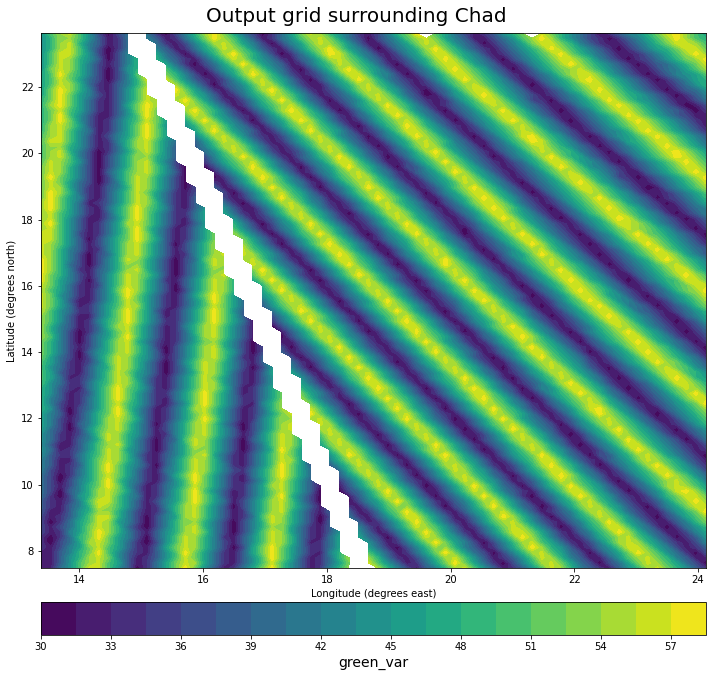

In [8]:
x_min, x_max = (13.3, 24.2)
y_min, y_max = (7.4, 23.7)

scale_extent_request = Request(collection=collection,
                               granule_id=[granule_ids['002_00_028_africa']],
                               scale_extent=[x_min, y_min, x_max, y_max])

scale_extent_job_id = harmony_client.submit(scale_extent_request)
scale_extent_results = wait_and_download_results(scale_extent_job_id)

plot_variable(scale_extent_results[0], 'green_var', 'lon', 'lat',
              'Output grid surrounding Chad', 'green_var',
              'Longitude (degrees east)', 'Latitude (degrees north)')

#### Target grid dimensions:

By default, the Swath Projector will derive an output grid extent and resolution from the input swath. It is possible to alter the output grid by specifying the number of pixels in the output grid in both the x and y dimensions. With the same extents, but different grid dimensions, the output grid resolution will be changed. This is acheived with the `height` and `width` request parameters:

{'username': 'olittlej', 'status': 'running', 'message': 'The job is being processed', 'progress': 0, 'createdAt': '2021-06-28T22:06:40.396Z', 'updatedAt': '2021-06-28T22:06:40.396Z', 'links': [{'title': 'Job Status', 'href': 'https://harmony.uat.earthdata.nasa.gov/jobs/104501e7-ad16-4984-bfc2-1c65f9b520c7', 'rel': 'self', 'type': 'application/json'}], 'request': 'https://harmony.uat.earthdata.nasa.gov/C1233860183-EEDTEST/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?forceAsync=true&granuleId=G1233860553-EEDTEST&width=250&height=250', 'numInputGranules': 1, 'jobID': '104501e7-ad16-4984-bfc2-1c65f9b520c7'}

Waiting for the job 104501e7-ad16-4984-bfc2-1c65f9b520c7 to finish


 [ Processing: 100% ] |###################################################| [|]



Downloaded files: ['015_02_210_europe_regridded.nc']


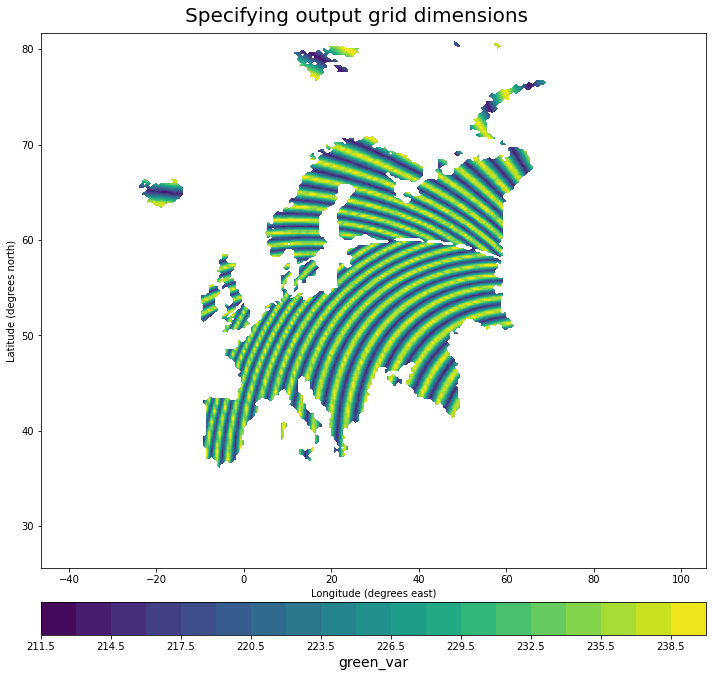

In [9]:
dimensions_request = Request(collection=collection,
                             granule_id=[granule_ids['015_02_210_europe']],
                             height=250,
                             width=250)

dimensions_job_id = harmony_client.submit(dimensions_request)
dimensions_results = wait_and_download_results(dimensions_job_id)

plot_variable(dimensions_results[0], 'green_var', 'lon', 'lat',
              'Specifying output grid dimensions', 'green_var',
              'Longitude (degrees east)', 'Latitude (degrees north)')

#### Target pixel scale:

The output pixel scales can be specified using the `scaleSize` keyword argument. Note that this cannot be specified at the same time as the dimensions of the output grid (`height` and `width`). In the request below, an output grid pixel scale of 0.5 degrees in both directions.

{'username': 'olittlej', 'status': 'running', 'message': 'The job is being processed', 'progress': 0, 'createdAt': '2021-06-28T22:07:25.178Z', 'updatedAt': '2021-06-28T22:07:25.178Z', 'links': [{'title': 'Job Status', 'href': 'https://harmony.uat.earthdata.nasa.gov/jobs/f2f484bb-0321-47a4-b4fa-51584910defc', 'rel': 'self', 'type': 'application/json'}], 'request': 'https://harmony.uat.earthdata.nasa.gov/C1233860183-EEDTEST/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?forceAsync=true&scaleSize=0.5&scaleSize=0.5&granuleId=G1233860551-EEDTEST', 'numInputGranules': 1, 'jobID': 'f2f484bb-0321-47a4-b4fa-51584910defc'}

Waiting for the job f2f484bb-0321-47a4-b4fa-51584910defc to finish


 [ Processing: 100% ] |###################################################| [|]



Downloaded files: ['015_01_210_australia_regridded.nc']


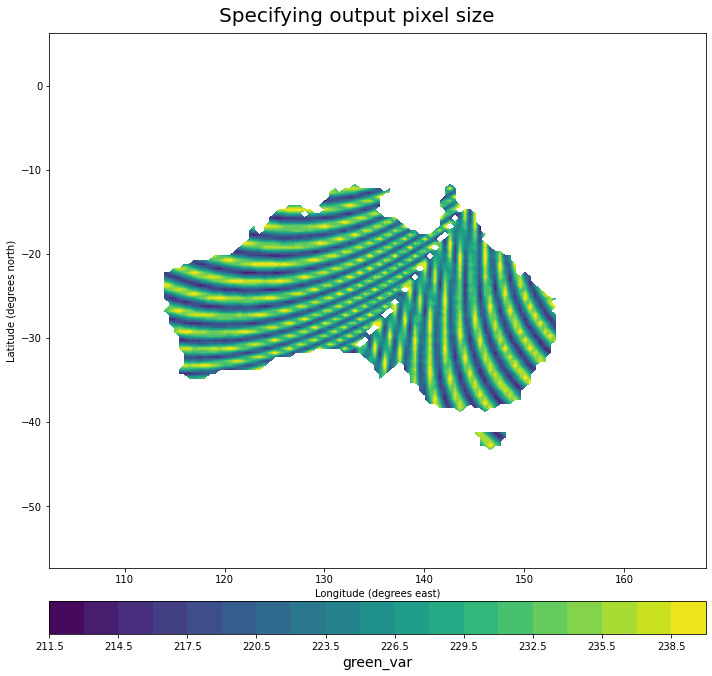

In [10]:
x_resolution = 0.5
y_resolution = 0.5

scale_size_request = Request(collection=collection,
                             granule_id=[granule_ids['015_01_210_australia']],
                             scale_size=[x_resolution, y_resolution])

scale_size_job_id = harmony_client.submit(scale_size_request)
scale_size_results = wait_and_download_results(scale_size_job_id)

plot_variable(scale_size_results[0], 'green_var', 'lon', 'lat',
              'Specifying output pixel size', 'green_var',
              'Longitude (degrees east)', 'Latitude (degrees north)')

#### Target grid CRS:

The projection of the output grid can be specified using the `crs` keyword argument. This is a string value that can either be an [EPSG code](https://epsg.org/home.html), or a [Proj string](https://proj.org/usage/quickstart.html).

The following request will specify that the [NSIDC EASE-2 global projection](https://nsidc.org/data/ease) is used:

{'username': 'olittlej', 'status': 'running', 'message': 'The job is being processed', 'progress': 0, 'createdAt': '2021-06-28T22:08:04.379Z', 'updatedAt': '2021-06-28T22:08:04.379Z', 'links': [{'title': 'Job Status', 'href': 'https://harmony.uat.earthdata.nasa.gov/jobs/8ac8937c-53bb-4dbb-b2da-48bd1640f3fa', 'rel': 'self', 'type': 'application/json'}], 'request': 'https://harmony.uat.earthdata.nasa.gov/C1233860183-EEDTEST/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?forceAsync=true&outputcrs=EPSG%3A6933&granuleId=G1233860549-EEDTEST', 'numInputGranules': 1, 'jobID': '8ac8937c-53bb-4dbb-b2da-48bd1640f3fa'}

Waiting for the job 8ac8937c-53bb-4dbb-b2da-48bd1640f3fa to finish


 [ Processing: 100% ] |###################################################| [|]



Downloaded files: ['015_00_210_africa_regridded.nc']


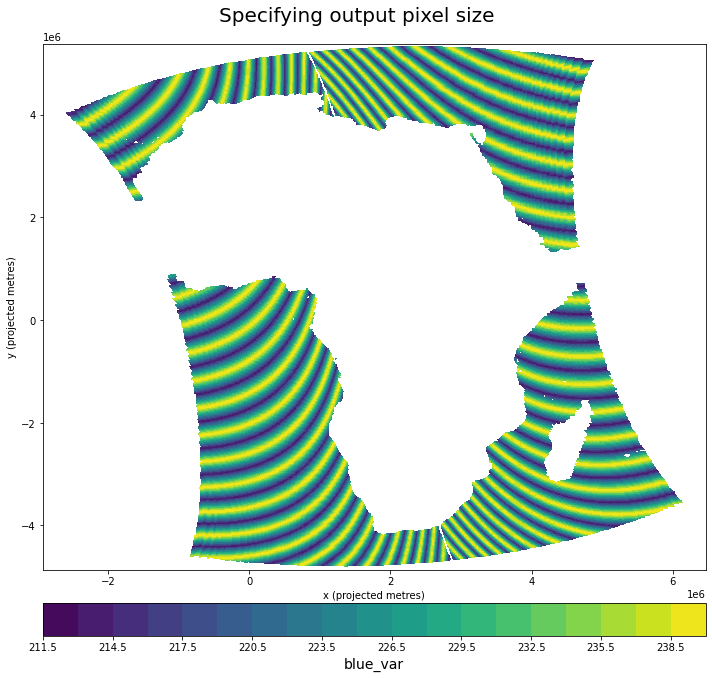

In [11]:
crs_epsg_request = Request(collection=collection,
                           granule_id=[granule_ids['015_00_210_africa']],
                           crs='EPSG:6933')

crs_epsg_job_id = harmony_client.submit(crs_epsg_request)
crs_epsg_results = wait_and_download_results(crs_epsg_job_id)

plot_variable(crs_epsg_results[0], 'blue_var', 'x', 'y',
              'Specifying output pixel size', 'blue_var',
              'x (projected metres)', 'y (projected metres)')